### 회귀 트리
- 회귀 함수를 기반으로 하지 않고 결정 트리와 같이 트리를 기반으로 하는 회귀 방식
- 트리 기반의 회귀 : 회귀 트리 이용
- 분류 트리와의 차이 : 분류가 특정 클래스 레이블을 결정하는 것과 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균을 구해 회귀 예측값 계산
- 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 사용 가능

#### 회귀 실습 - 자전거 대여 수요 예측

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

bostonDF = pd.DataFrame(data, columns=["CRIM","ZN","INDUS","CHAS", "NOX","RM","AGE", "DIS","RAD","TAX","PTRATIO","B" ," LSTAT" ])
bostonDF["PRICE"] = target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

rf = RandomForestRegressor(random_state = 0, n_estimators = 1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring = 'neg_mean_squared_error', cv=5)
rmse_scores =  np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 negative MSE scores : ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE scores : {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 negative MSE scores :  [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE scores : 4.423


In [13]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = 'neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    print('####', model.__class__.__name__, '####')
    print('5 교차 검증의 평균 RMSE : {0:3f}'.format(avg_rmse))

다양한 유형의 회귀 트리를 생성하고 이를 이용해 보스턴 주택 가격을 예측

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

# 트리 기반의 회귀 모델을 반복하며 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models :
    get_model_cv_prediction(model, X_data, y_target)

#### DecisionTreeRegressor ####
5 교차 검증의 평균 RMSE : 4.422539
#### RandomForestRegressor ####
5 교차 검증의 평균 RMSE : 4.422539
#### GradientBoostingRegressor ####
5 교차 검증의 평균 RMSE : 4.422539
#### XGBRegressor ####
5 교차 검증의 평균 RMSE : 4.422539
#### LGBMRegressor ####
5 교차 검증의 평균 RMSE : 4.422539


- Regressor 클래스는 선형 회귀와 다른 처리 방식이므로 coef_가 없음
- 피처별 중요도 시각화

<Axes: >

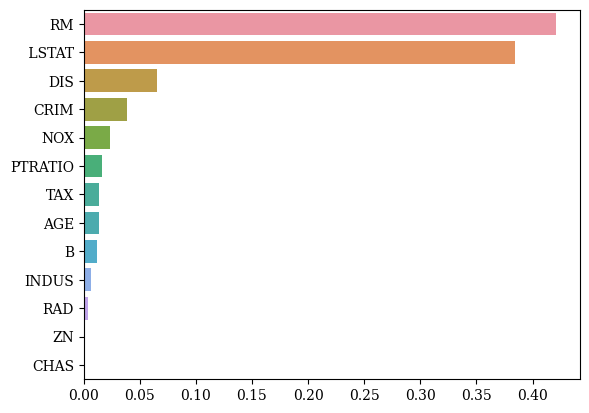

In [15]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators = 1000)

# 앞 예제에서 만들어진 x_data, y_target 데이터 세트를 적용해 학습
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x=feature_series, y = feature_series.index)

max_depth 크기를 변화하면서 회귀 트리 예측선의 변화 알아보기

(100, 2)


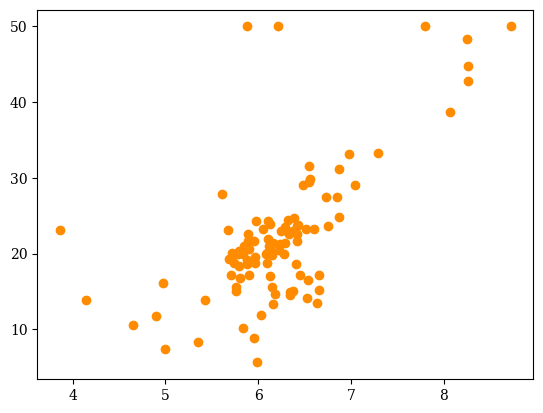

In [17]:
import matplotlib.pyplot as plt 
bostonDF_sample = bostonDF[['RM' ,'PRICE']] # 2차원 상에서 회귀 예측선을 쉽게 표현하기 위해 가장 중요도 높은 rm만
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression
# 선형 회귀와 결정 트리 기반의 regressor 생성, DecisionTreeRegressor max_depth는 각각 2,7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth = 2)
rf_reg7 = DecisionTreeRegressor(max_depth = 7)

# 실제 예측 적용할 테스트용 데이터 세트를 4.5-8.5까지의 100개 데이터 세트로 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 rm만, 그리고 결정 데이터인 price 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

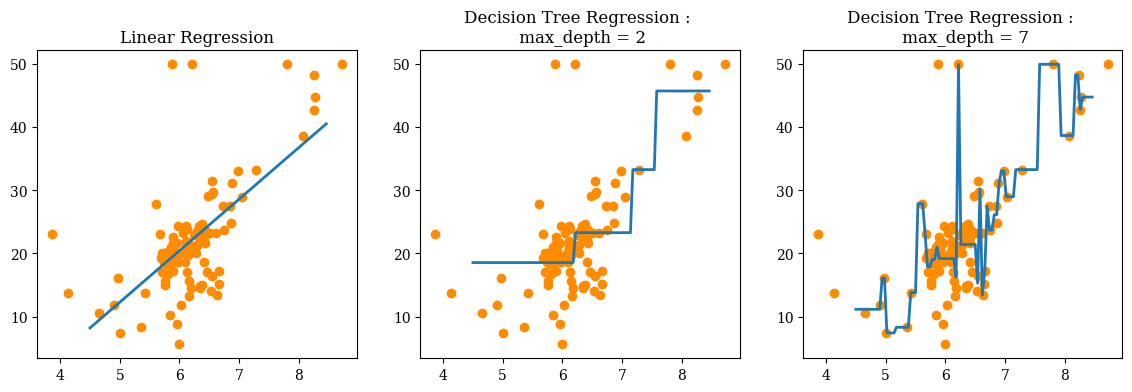

In [21]:
fig , (ax1, ax2, ax3) = plt.subplots(figsize = (14,4), ncols = 3)

# X축 값을 4.5~ 8.5로 변환하며 입력했을 때 선형회귀와 결정 트리 회귀 예측선 시각화
#선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax1.plot(X_test, pred_lr,label = "linear", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression : \n max_depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax2.plot(X_test, pred_rf2, label = "max_depth : 3", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression : \n max_depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax3.plot(X_test, pred_rf7, label = "max_depth : 7", linewidth = 2)

자전거 대여 수요 예측

데이터 클렌징 및 가공

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
bike_df = pd.read_csv('biketrain.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
bike_df.info()

# datetime 만 object형 (시간이므로 가공이 필요)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [9]:
drop_columns = ['datetime', 'casual', 'registered'] 
bike_df.drop(drop_columns, axis=1, inplace =True) 

In [23]:
# 오류값의 로그에 대한 RMSE
# 사이킷런은 RMSLE를 제공하지 않으므로 평가함수 만듦
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

rmsle를 구할 때 데이터의 크기에 따라 오버/언더플로가 발생하기 쉬움

In [18]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽습니다
def rmsle(y, pred) :
     msle = mean_squared_log_error(y, pred)
     rmsle = np.sqrt(mse)
     return rmsle
# 따라서 log1p를 이용 (1+log())

#### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis = 1,inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size = 0.3, random_state = 0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test,pred)

# 실제 값인 대여 횟수를 감안하면 비교적 큰 값

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [28]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측값을 서로 비교 할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
   
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending = False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops = 5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

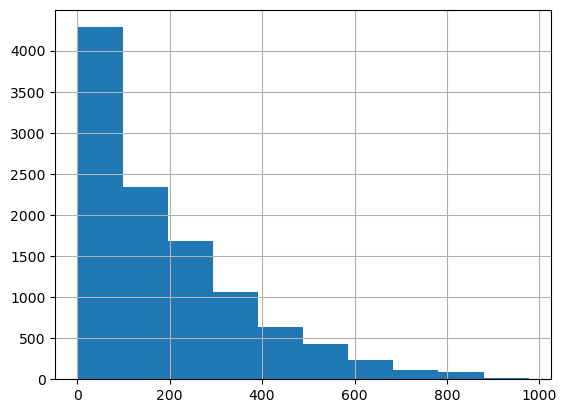

In [30]:
y_target.hist()
# 정규분포가 아닌 0-200 사이에 왜곡돼 있음.
# 로그를 적용해 정규분포로 변환 가능

<Axes: >

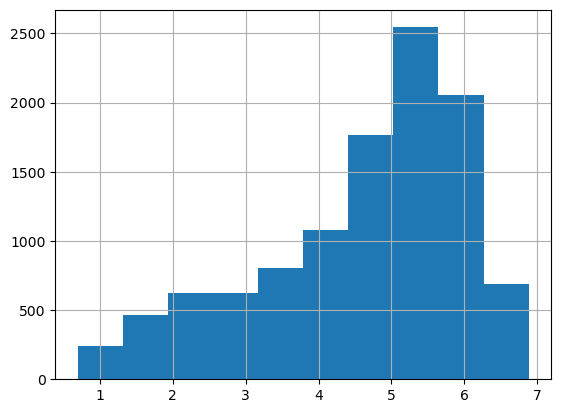

In [33]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

# 완전한 정규 분포는 아니지만 왜곡이 많이 개선됨

In [35]:
# 타깃 칼럼인 count값을 로그변환
y_target_log = np.log1p(y_target)
# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log,
                                                   test_size = 0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
# 테스트 데이터 세트의 target값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일 변환
y_test_exp = np.expm1(y_test)
# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 에측했으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)
evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<Axes: >

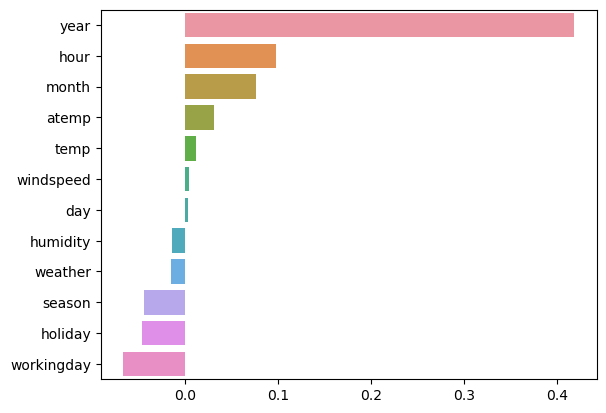

In [36]:
coef = pd.Series(lr_reg.coef_, index= X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

year의 회귀 계수 값이 큰 값을 가지고 있음.
year에 따라 자전거 대여 횟수의 영향이 크다는 것은 납득하기 어려움.
* 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있음. -> 원핫 인코딩 적용해 변환

In [37]:
# year, month, day, hour를 one hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day',
                                                    'hour', 'holiday', 'workingday',
                                                    'season', 'weather'])

In [38]:
# 원핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, 
                                                   test_size = 0.3, random_state=0)
# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False) :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('####', model.__class__.__name__, '####')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha = 0.01)

for model in [lr_reg, ridge_reg, lasso_reg] :
    get_model_predict(model , X_train, X_test, y_train, y_test, is_expm1=True)

#### LinearRegression ####
RMSLE: 0.590, RMSE: 97.690, MAE: 63.383
#### Ridge ####
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
#### Lasso ####
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: >

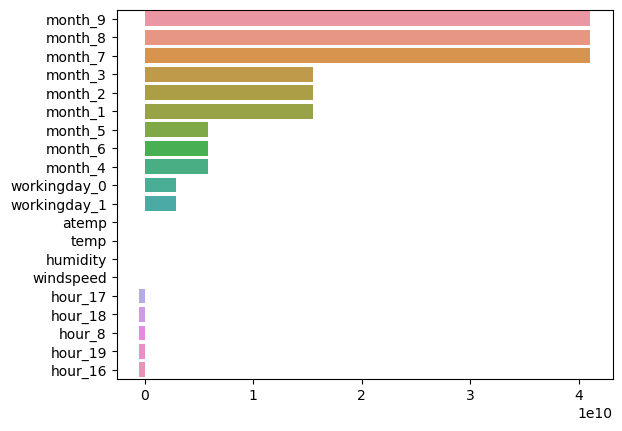

In [39]:
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

회귀 트리를 이용해 회귀 예측 수행

In [41]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트 , GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg] :
    # xgboost의 경우 df이 입력될 경우 오류 발생 가능. ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values,
                     y_test.values, is_expm1 = True)

#### RandomForestRegressor ####
RMSLE: 0.354, RMSE: 50.412, MAE: 31.131
#### GradientBoostingRegressor ####
RMSLE: 0.330, RMSE: 53.352, MAE: 32.755
#### XGBRegressor ####
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
#### LGBMRegressor ####
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
